In [1]:
from pathlib import Path
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt


In [15]:
INJECTION_DATA_DIR = Path('data/inj/')
PORE_PRESSURE_DATA_DIR = Path('data/pp/')
ETAS_DATA_DIR = Path('data/etas1/')



In [16]:
def parse_year_month(year_month):
    year = int(np.floor(year_month))
    month_dec = np.round(year_month - year, 2)
    month_int = int(np.round(month_dec * 12))
    return [year, month_int]

In [37]:
df_pp = pd.read_csv(filename, sep=' ', header=None, names=['year_month', 'pp'])


,year_month,pp
0,2011.00,0.000000
1,2011.00,0.000000
2,2011.00,0.000000
3,2011.00,0.758424
4,2011.00,0.000000
...,...,...
1255,2018.92,0.000000
1256,2018.92,0.000000
1257,2018.92,5.970860
1258,2018.92,0.000000


In [17]:

def parse_pp_data(filename):
    """
    Returns longitude, lattitude, pore pressure dataframe for a given pore pressure data file
    """    
#     print(filename)
    df_pp = pd.read_csv(filename, sep=' ', header=None, names=['year_month', 'pp'])
    df_pp = df_pp.groupby('year_month').agg(sum).reset_index()
    # convert year_month from decimal format to year, month integer format
    x = df_pp.year_month.apply(parse_year_month)
    df_temp = pd.DataFrame(x.to_list(), columns=['year', 'month'])
    df_pp = pd.concat([df_temp, df_pp], axis=1)

    fname_split = filename.stem.split('_')
    return fname_split[1], fname_split[2], df_pp


In [19]:
# prepare pore pressure data
pore_pressure_data_files = list(PORE_PRESSURE_DATA_DIR.glob('*.txt'))
pp_lat_lon_data = {}
for filename in pore_pressure_data_files:
    lat, lon, df_pp = parse_pp_data(filename)
    pp_lat_lon_data[lat, lon] = df_pp


In [187]:
def parse_date(date):
    return 2010 + date/365

In [242]:
def parse_etas1_data(filename): 
    df_etas1 = pd.read_csv(filename, delim_whitespace=True, names=['first_event_number', 'last_event_number','starting_date','ending_date','AIC','K','mu'])
    # calculate lambda    
    df_etas1['lambda'] = (df_etas1['last_event_number'] - df_etas1['first_event_number'] + 1) \
                         / (df_etas1['ending_date'] - df_etas1['starting_date'])
    # convert start/end date from dates.float to year/month/date format
    new_start_date = df_etas1.starting_date.apply(parse_date)
    new_end_date = df_etas1.ending_date.apply(parse_date)
    df_etas1['new_start_date'] = new_start_date
    df_etas1['new_end_date'] = new_end_date
    
    fname_split = filename.stem.split('_')
    return fname_split[1], fname_split[2], df_etas1
    

In [194]:
#filename = 'data/etas1/seism_96.6_35.6_R20_200_50.etas1'
#df_etas1 = pd.read_csv(filename, delim_whitespace=True, names=['first_event_number', 'last_event_number','starting_date','ending_date','AIC','K','mu'])

#new_start_date = df_etas1.starting_date.apply(parse_starting_date)
#new_end_date = df_etas1.ending_date.apply(parse_ending_date)
#df_etas1['new_start_date'] = new_start_date
#df_etas1

#for index, row in df_etas1.iterrows():
#    print((row['last_event_number'] - row['first_event_number'] + 1)/(row['ending_date'] - row['starting_date']))



In [243]:
# prepare etas1 mu,K,lambda data
etas1_data_files = list(ETAS_DATA_DIR.glob('*.etas1'))
etas1_lat_lon_data = {}
for filename in etas1_data_files:
    lat,lon,df_etas1 = parse_etas1_data(filename)
    etas1_lat_lon_data[lat, lon] = df_etas1

In [246]:
def parse_injection_data(filename):
    """
    Returns longitude, lattitude, injection volume dataframe for a given injection volume data file
    """
#     print(filename)
    df_inj = pd.read_csv(filename, sep=' ', header=None, names=['year_month', 'injection_volume'])
    # convert year_month from decimal format to year, month integer format
    x = df_inj.year_month.apply(parse_year_month)
    df_temp = pd.DataFrame(x.to_list(), columns=['year', 'month'])
    df_inj = pd.concat([df_temp, df_inj], axis=1)

    fname_split = filename.stem.split('_')
    return fname_split[1], fname_split[2], df_inj


In [247]:
# prepare injection data
injection_data_files = list(INJECTION_DATA_DIR.glob('*.txt'))
injection_lat_lon_data = {}
for filename in injection_data_files:
    lat, lon, df_inj = parse_injection_data(filename)
    injection_lat_lon_data[lat, lon] = df_inj



## Plotting

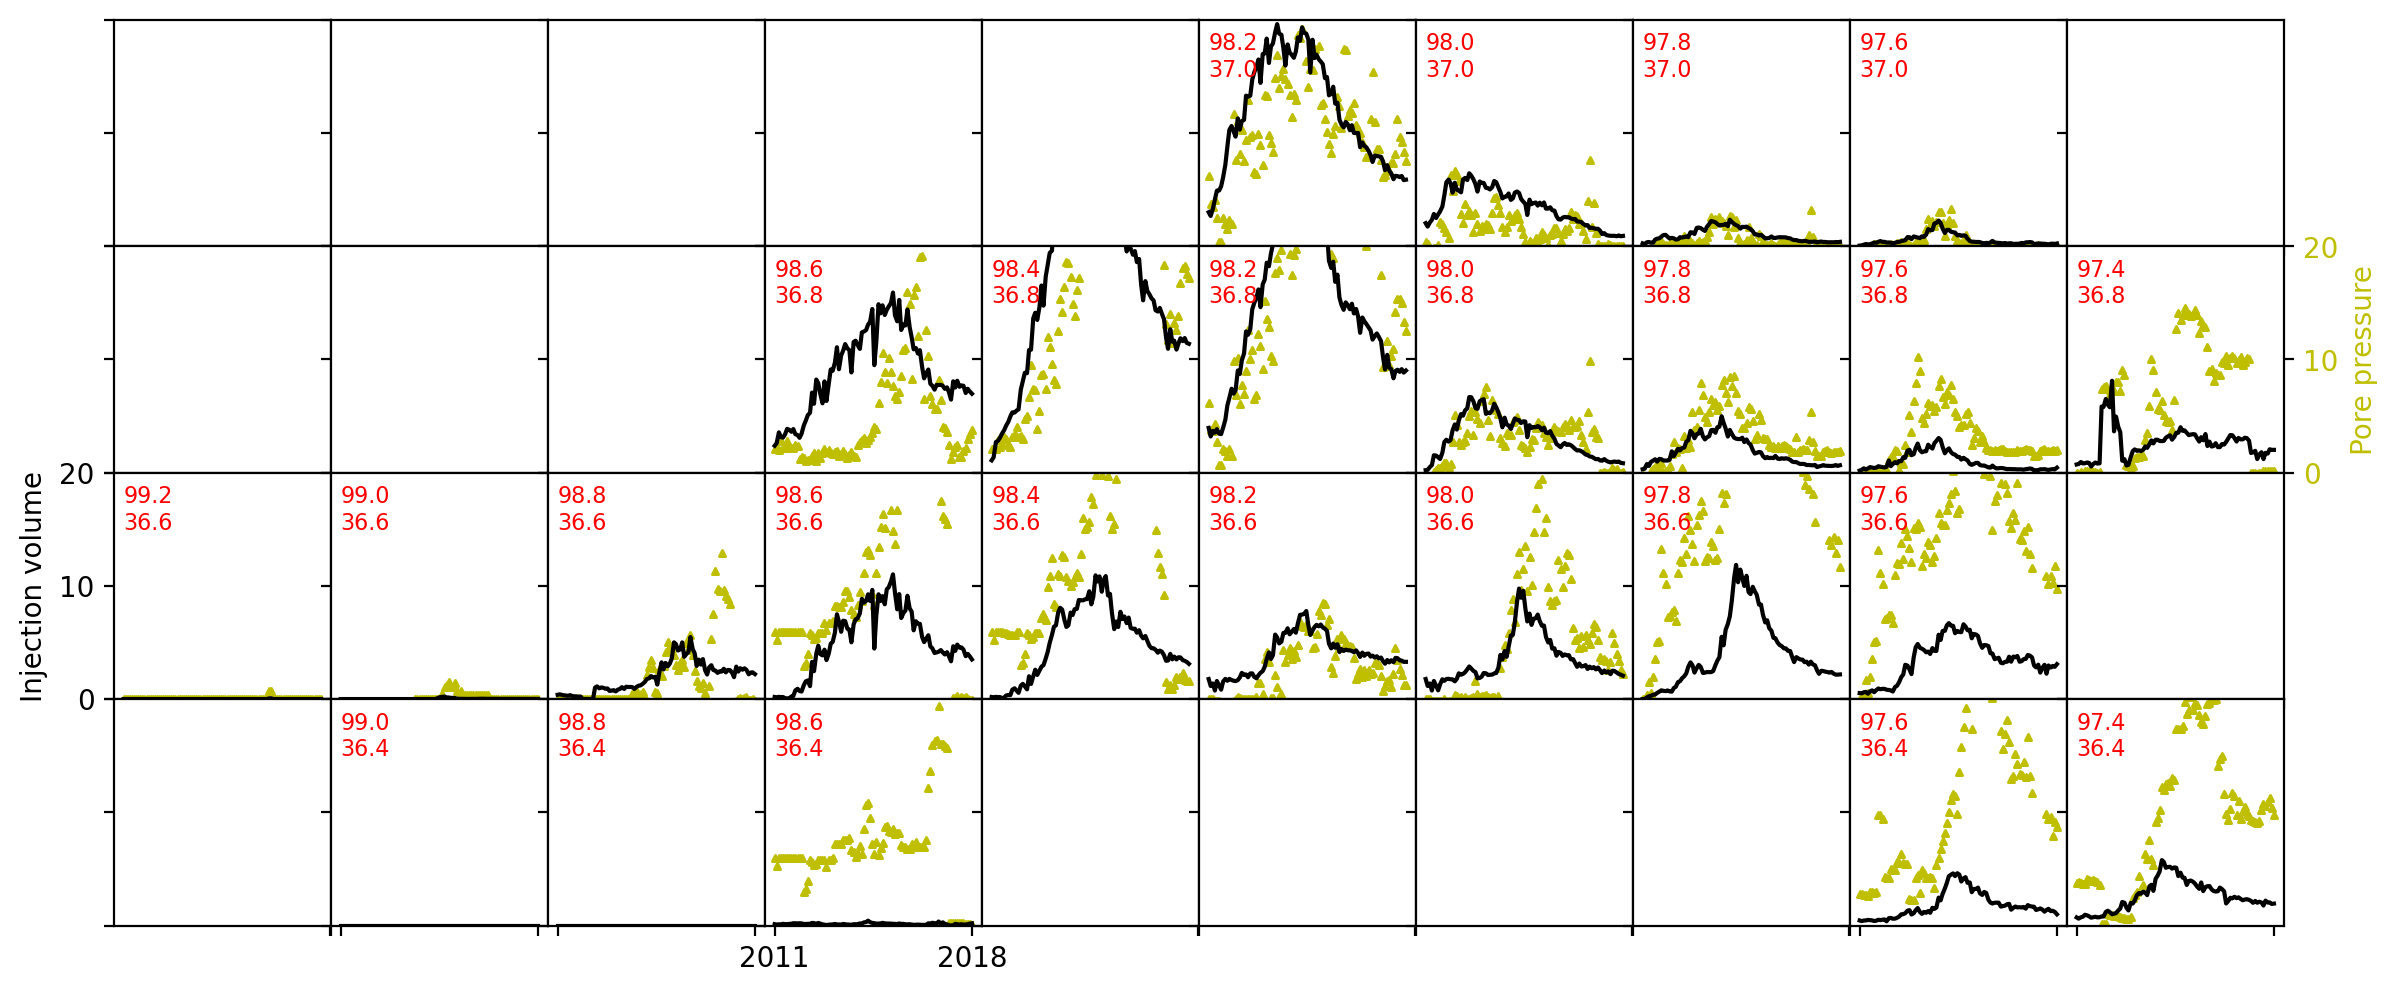

In [138]:
fig, axes = plt.subplots(4, 10, sharex=False, sharey=False, figsize=(14,6), dpi=200)
axes = axes.ravel()

max_inj_vol = 20

ax_idx = 0
init=False
for lon in np.arange(37.0, 36.2, -0.2):
    for lat in np.arange(99.2, 97.2, -0.2):
        ax = axes[ax_idx]
        lat_s = "%3.1f"%(lat)
        lon_s = "%3.1f"%(lon)
        if (lat_s,lon_s) in injection_lat_lon_data.keys():
#             print(lat_s, lon_s)
            df_inj = injection_lat_lon_data[(lat_s,lon_s)]
            # plot injection volume
            ax.plot(df_inj.year_month,df_inj.injection_volume, color='k')
            # plot pore pressure
            df_pp = pp_lat_lon_data[(lat_s,lon_s)] 
            
            if not df_pp.empty:
                ax.scatter(df_pp.year_month,df_pp.pp, marker="^", color='y', s=5)
            # co-ordinate text overlay
            ax.text(2011.00, max_inj_vol - 5, '%s\n%s'%(lat_s, lon_s), fontsize=8, color='r')

        # set injection volume limit
        ax.set_ylim([0, max_inj_vol])
        yticks = np.linspace(0, max_inj_vol, 3).astype('int')
        ax.set_yticks(yticks)
        ax.set_xticks([2011.00, 2018.92])
        
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # injection volume y axis label
        if lat_s == "99.2" and lon_s == "36.6":
            ax.set_yticklabels(yticks, color='k')
            ax.set_ylabel("Injection volume", color='k')
        # injection volume y axis label
        if lat_s == "97.4" and lon_s == "36.8":
            ax.yaxis.tick_right()
            ax.set_yticklabels(yticks, color='y', )
            ax.set_ylabel("Pore pressure", color='y')
            ax.yaxis.set_label_position("right")

        if lat_s == "98.6" and lon_s == "36.4":
            ax.set_xticklabels([2011, 2018])
        
        ax_idx += 1

# fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [249]:
def plot_etas_single(ax, df_etas1, column, color):
    
    ax.hlines(y = df_etas1[column], xmin = df_etas1.new_start_date, xmax = df_etas1.new_end_date,
              linewidth=0.5, color=color)

    # triangle in center of hline
    x = df_etas1.new_start_date + ((df_etas1.new_end_date - df_etas1.new_start_date) / 2.0)
    y = df_etas1[column]
    ax.scatter(x, y, marker="^", color=color, s=5)



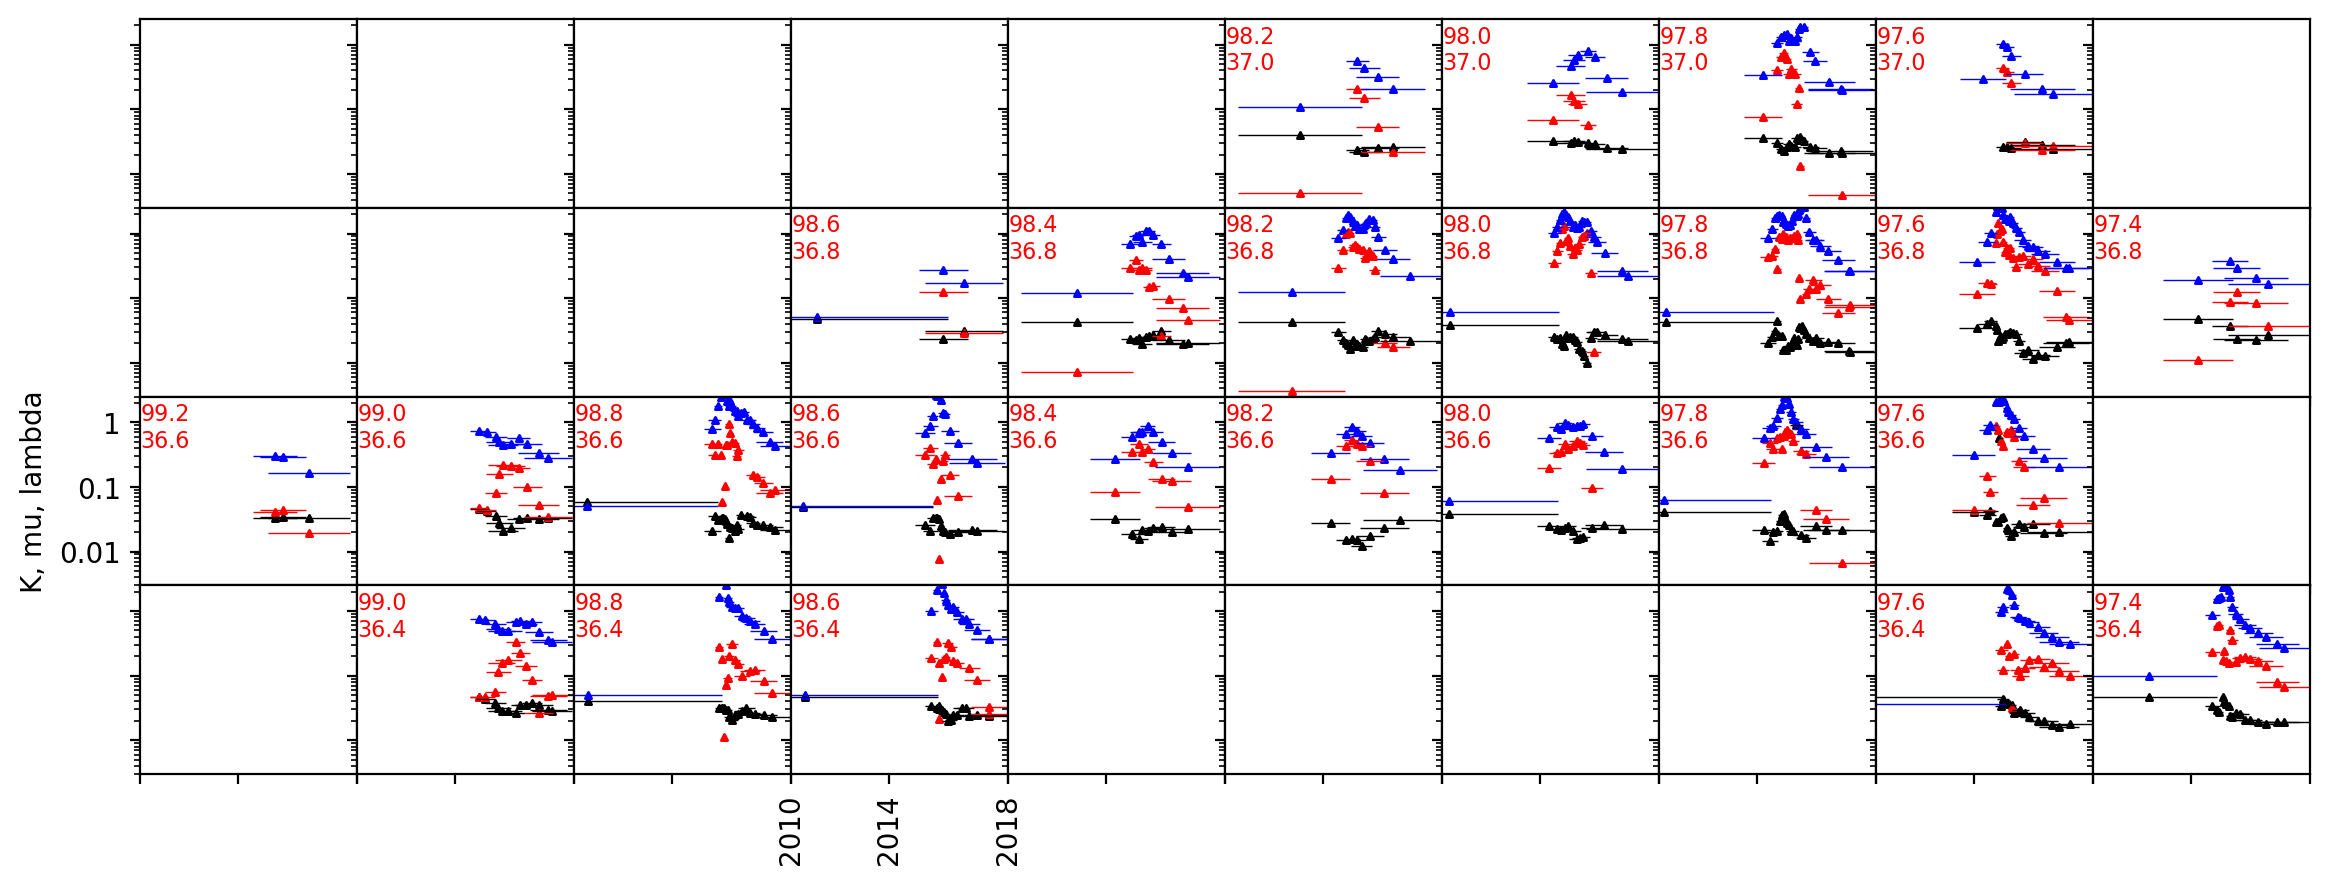

In [270]:
fig, axes = plt.subplots(4, 10, sharex=False, sharey=False, figsize=(14,5), dpi=200)
axes = axes.ravel()

min_k_val = 0.003
max_k_val = 2.5

ax_idx = 0
init=False
for lon in np.arange(37.0, 36.2, -0.2):
    for lat in np.arange(99.2, 97.2, -0.2):
        ax = axes[ax_idx]
        lat_s = "%3.1f"%(lat)
        lon_s = "%3.1f"%(lon)

        if (lat_s,lon_s) in etas1_lat_lon_data:
           #plot etas1 mu,K,lambda
            df_etas1 = etas1_lat_lon_data[lat_s, lon_s]
            plot_etas_single(ax, df_etas1, 'K', color='k')
            plot_etas_single(ax, df_etas1, 'mu', color='r')
            plot_etas_single(ax, df_etas1, 'lambda', color='b')

            # co-ordinate text overlay
            ax.text(2010.00, max_k_val - max_k_val/1.2, '%s\n%s'%(lat_s, lon_s), fontsize=8, color='r')

        # set limit and ticks
        ax.set_yscale("log")
        ax.set_xlim([2010.00, 2018.92])    
        ax.set_ylim([min_k_val, max_k_val])
        yticks = [1, 0.1, 0.01]
        ax.set_yticks(yticks)
        ax.set_xticks([2010.00, 2014.00, 2018.92])
        ax.set_xticklabels([2010, 2014, 2018], rotation=90)

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # injection volume y axis label
        if lat_s == "99.2" and lon_s == "36.6":
            ax.set_yticklabels(yticks, color='k')
            ax.set_ylabel("K, mu, lambda", color='k')            

        if lat_s == "98.6" and lon_s == "36.4":
            ax.set_xticklabels([2010, 2014, 2018])
        
        ax_idx += 1

# fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()